# ECE1508: Deep Generative Models -- SUM25
## Assignment 2: Explicit Methods for Data Generation
### Programming Part
This assignment reviews explicit generation methods, as well as some basic experiment with image generation. For each task, some explanations have been given and some starter code has been provided. Please complete the provided code and report your observations and conclusions for each part in the provided markdown. For submission, please pay attention to the instructions. Failure to following the instructions can lead to mark deduction.

Let's start with loading necessary libraries. And defining the `device`.

In [50]:
import torch, torchvision
from torch.utils.data import DataLoader, Subset, random_split
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, MNIST
import matplotlib.pyplot as plt


import numpy as np
import random
import math

# wired package to solve the kernel crash issue when plotting on jupyter lab and cuda
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


# select a device that we want to shift the process on: cuda, cpu, mps
if torch.backends.mps.is_built():
    device = "mps"
elif torch.backends.cuda.is_built():
    device = "cuda"
else:
    device = "cpu"
    
#print GPU INFO
print(f"GPU: {torch.cuda.get_device_name(device)}")
print(f"Total GPU Memory: {torch.cuda.get_device_properties(device).total_memory / (1024**3):.2f} GB")

GPU: NVIDIA GeForce RTX 3070 Laptop GPU
Total GPU Memory: 8.00 GB


## Programming Question 1: Image Inpainiting with Masked CNN

### General Overview
In this assignment, we intend to train a masked CNN model for _image inpainting._ Image inpainting refers to completing or fixing missed or corrupted pixels in an image. This is one of the well-known tasks, we can do by generative model, especially the AR models, as then can predict each pixel given its neighboring ones. In the sequel, we do this step by step.

### Dataset Loading
As the first step we load `CIFAR-10`.

In [2]:
# Define transformation: resize, tensorize, normalize
transform = transforms.Compose([
    # transforms.Resize(24),  # Optional: downsample if you have limited computation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-10
full_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)

# Select only three classes for simplicity and fast training
target_classes = ['airplane', 'cat', 'dog']
class_to_idx = {name: i for i, name in enumerate(full_dataset.classes)}
selected_indices = [i for i, (_, label) in enumerate(full_dataset) if full_dataset.classes[label] in target_classes]

# shuffle and subsample to k images
random.seed(42) # for reproducibility
k = 3000  # k images are selected at random

# sample the subset
sample_subset = Subset(full_dataset, selected_indices)

# Split into train/test
train_ratio = 0.8
train_size = int(train_ratio * len(sample_subset))  # COMPLETE
test_size = len(sample_subset) - train_size  # COMPLETE
train_subset, test_subset = random_split(sample_subset, [train_size, test_size])

# Create loaders
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

### Looking into some example
Let's write a function to show the first `N` images of a batch of images.

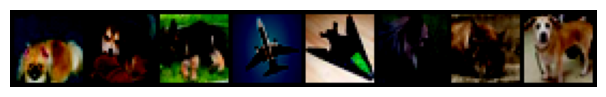

In [3]:
# Show a few images from loader
def show_samples(image_batch, N=8):
    '''
    N: number of samples
    '''
    grid = torchvision.utils.make_grid(image_batch[:N].detach().cpu(), nrow=N) #need to move to cpu
    npimg = grid.numpy()
    plt.figure(figsize=(N,1))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Preview a batch
batch = next(iter(test_loader))
image_batch, _ = batch
# COMPLETE
show_samples(image_batch)

### Masking for Image Corruption
We now write a function that can _mask_ some pixels in images. We consider both `block` and `random` masking.

In [4]:
def apply_mask(images, mask_type='block', mask_ratio=0.5):
    """
    Apply a mask to a batch of images.
    Args:
        images: Tensor of shape [B, C, H, W] == batch, channel_num, height, width
        mask_type: 'block' or 'random'
        mask_ratio: fraction of image pixels to mask
    Returns:
        masked_images: Tensor with masked pixels set to 0 of shape [B, C, H, W]
        masks: Binary mask (1 = visible, 0 = masked) of shape [B, C, H, W]
    """
    # read the shapes
    B, C, H, W = images.shape

    # We consider the same mask for all channels
    # start with all ones
    masks = torch.ones((B, H, W), dtype=torch.float32, device= images.device )

    if mask_type == 'block':
        # Mask a center block (e.g., 50% area)
        bh = int(H * mask_ratio**0.5)
        bw = int(W * mask_ratio**0.5)
        top = (H - bh) // 2
        left = (W - bw) // 2
        masks[:, top:top+bh, left:left+bw] = 0

    elif mask_type == 'random':
        for i in range(B):
            num_mask = int(H * W * mask_ratio)
            idx = torch.randperm(H * W, device=images.device)[:num_mask]
            masks[i].view(-1)[idx] = 0

    # Copy the mask in all C channels
    masks = masks.unsqueeze(1).expand(-1, C, -1, -1)

    # Apply mask to the images
    masked_images = images * masks.to(images.device)

    return masked_images, masks


Now let's take a look at a few masked images using the `show_samples()` function.

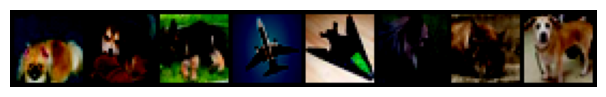

In [5]:
# Get a batch of images
images, _ = next(iter(test_loader))

# Apply mask
masked_images, masks = apply_mask(images.to(device), mask_type='block')

# Preview original and masked ones
show_samples(images.to(device), 8)




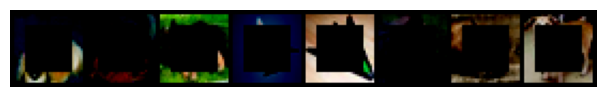

In [6]:
show_samples(masked_images)

### Implementing AR Model
We next implement a masked CNN to learn the data distribution in AR manner. To this end, we first modify the class `nn.Conv2d` to `MaskedConv2d` which further applies masking.

In [7]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, *args, mask_type = 'B', **kwargs):
        super().__init__(*args, **kwargs)
        assert mask_type in ['A', 'B']
        self.register_buffer('mask', torch.ones_like(self.weight.data))
        _, _, h, w = self.weight.size()
        # add mask to the convolution
        self.mask[:, :, h // 2, w // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, h // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)

Using `MaskedConv2d`, we now implement a simple Masked CNN with 3 masked convolutional layers with the first two layers being ReLU-activated. For the first layer use `mask_type = 'A'` and for the remaining `mask_type = 'B'`.

In [8]:
class MyMaskedCNN(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=64, num_classes=256):
        super().__init__()
        self.num_channels = in_channels
        self.num_classes = num_classes

        self.net = nn.Sequential(
            MaskedConv2d(in_channels, hidden_channels, kernel_size=3, padding=1, mask_type='A'),
            nn.ReLU(),
            MaskedConv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1, mask_type='B'),
            nn.ReLU(),
            MaskedConv2d(hidden_channels, num_classes, kernel_size=1, mask_type='B')
        )

    def forward(self, x):
       return self.net(x)

### Training Masked CNN
We next train the masked CNN using teacher-forcing technique: in each iteration, we pass masked image (corrupted one) through the model and compare it against the true image.

In [9]:
def train_model(model, dataloader, num_epochs=30, lr=1e-3, mask_type='block', num_classes=256):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss(reduction='none')  # mask-aware

    for epoch in range(num_epochs):
        total_loss = 0.0
        for images, _ in dataloader:
            images = images.to(device)  # [B, 3, H, W]
            masked_images, masks = apply_mask(images, mask_type)
            masked_images = masked_images.to(device)
            masks = masks.to(device)

            # Quantize target pixel values from (0,1) back to integer class labels (0–255)
            labels = (images.clamp(0, 1) * 255).long().clamp(0, num_classes - 1)

            output = model(masked_images) # [B, 3, 256, H, W]

            loss = 0.0
            for ch in range(3):
                # Get channel-specific logits and targets
                logits = output       # [B, 256, H, W]
                target_ch =  labels[:, ch, :, :]  # [B, H, W]
                mask_ch = masks[:, ch, :, :]  # [B, H, W]


                loss +=( (loss_fn(logits, target_ch) * (1 - mask_ch)).sum()) /( (1 - mask_ch).sum())

            loss = loss / 3.0  # average over 3 channels

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(dataloader):.4f}")



We can now train the masked CNN.

In [10]:
model = MyMaskedCNN(3, 64, 256)
train_model(model, train_loader, 30, 1e-3,'block', 256)


Epoch 1/30, Loss: 3.0866
Epoch 2/30, Loss: 2.8917
Epoch 3/30, Loss: 2.8825
Epoch 4/30, Loss: 2.8744
Epoch 5/30, Loss: 2.8680
Epoch 6/30, Loss: 2.8636
Epoch 7/30, Loss: 2.8605
Epoch 8/30, Loss: 2.8584
Epoch 9/30, Loss: 2.8566
Epoch 10/30, Loss: 2.8546
Epoch 11/30, Loss: 2.8539
Epoch 12/30, Loss: 2.8521
Epoch 13/30, Loss: 2.8516
Epoch 14/30, Loss: 2.8504
Epoch 15/30, Loss: 2.8501
Epoch 16/30, Loss: 2.8494
Epoch 17/30, Loss: 2.8485
Epoch 18/30, Loss: 2.8485
Epoch 19/30, Loss: 2.8478
Epoch 20/30, Loss: 2.8470
Epoch 21/30, Loss: 2.8464
Epoch 22/30, Loss: 2.8460
Epoch 23/30, Loss: 2.8456
Epoch 24/30, Loss: 2.8453
Epoch 25/30, Loss: 2.8450
Epoch 26/30, Loss: 2.8445
Epoch 27/30, Loss: 2.8443
Epoch 28/30, Loss: 2.8443
Epoch 29/30, Loss: 2.8436
Epoch 30/30, Loss: 2.8435


### Sampling and Inpainting
We now sample from the model: we pass the masked images (from test set) and autoregressively sample from it.

In [11]:
def autoregressive_sample(model, masked_images, mask, num_classes=256, visualize=True):
    model.eval()

    B, C, H, W = masked_images.shape
    masked_images = masked_images.to(device)
    mask = mask.to(device)

    sampled = masked_images.clone()

    with torch.no_grad():
        for i in range(H):
            for j in range(W):
                for ch in range(C):  # RGB channels
                    # Only predict if pixel was masked
                    to_fill = (mask[:, ch, i, j] == 0)
                    if to_fill.sum() == 0:
                        continue

                    out = model(sampled)
                    logits = out[:, :, i, j] # [B, 256] logits for pixel (i,j)

                    probs = F.softmax(logits / 1.0, dim=1)
                    sampled_values =  torch.multinomial(probs, 1) #sample using torch.multinomial

                    # Scale back to [0, 1]
                    sampled_values = sampled_values.squeeze(1).float() / (num_classes - 1)

                    sampled[to_fill, ch, i, j] = sampled_values

    if visualize:
        for i in range(min(B, 8)):
            fig, axs = plt.subplots(1, 3, figsize=(9, 3))
            axs[0].imshow(np.transpose(image_batch[i].cpu().numpy(), (1, 2, 0)))
            axs[1].imshow(np.transpose(masked_images[i].cpu().numpy(), (1, 2, 0)))
            axs[2].imshow(np.transpose(sampled[i].cpu().numpy(), (1, 2, 0)))
            for ax in axs: ax.axis('off')
            axs[0].set_title("Original")
            axs[1].set_title("Masked")
            axs[2].set_title("Sampled")
            plt.show()

    return sampled

Let us now have a few samples.

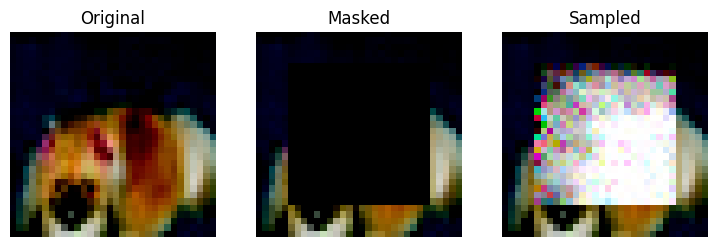

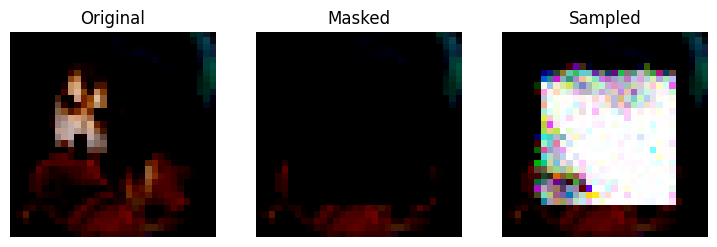

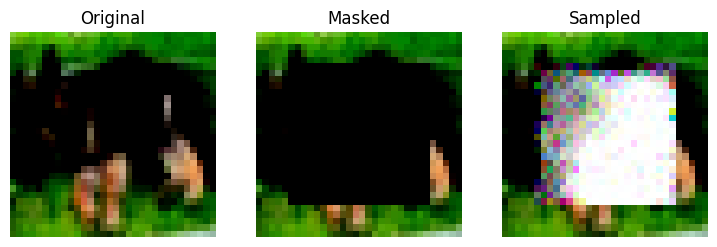

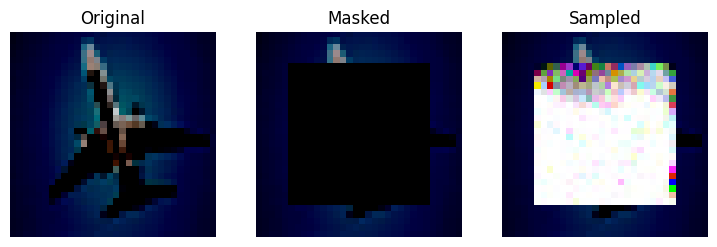

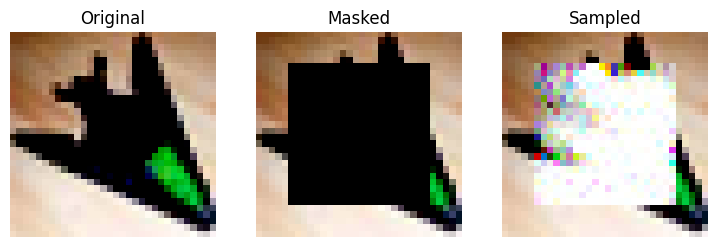

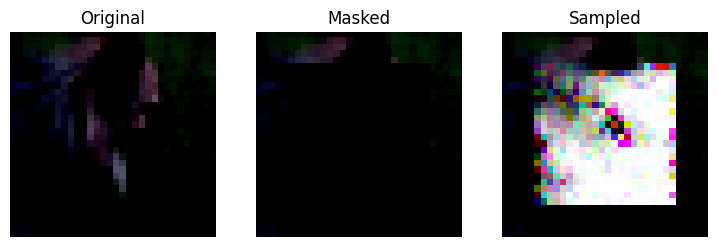

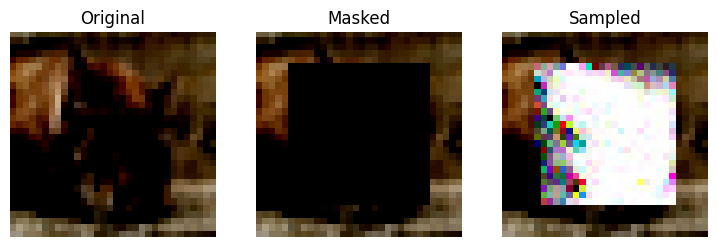

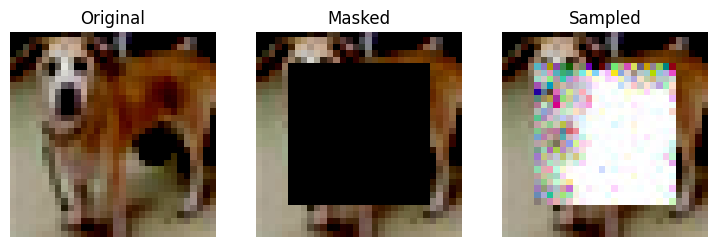

In [12]:
image_batch, _ = next(iter(test_loader))
masked_images, mask = apply_mask(image_batch,'block', 0.5)

_ = autoregressive_sample(model, masked_images, mask, visualize=True)

### Characterizing MSE and PSNR
Two evaluation metrics we can use to evaluate inpainting are MSE and PSNR. In MSE, we compute the difference between the true and reconstructed images. PSNR is defined as

$$ \mathrm{PSNR} = \frac{x_{\max}^2}{\mathrm{MSE}} $$

for some maximum value $x_{\max}$. PSNR is typically reported in dB. We now implement these two metrics.

In [13]:
# Compute the MSE
def compute_mse(original, reconstructed, mask):
    """
    Computes MSE only over masked regions.
    """
    mse = F.mse_loss(original * (1 - mask), reconstructed * (1 - mask), reduction='mean')
    return mse.item()

# Compute PSNR
def compute_psnr(original, reconstructed, mask, max_val=1.0):
    """
    Computes PSNR over masked regions.
    """
    max_val = torch.tensor(max_val, device=original.device)
    mse = F.mse_loss(original * (1 - mask), reconstructed * (1 - mask), reduction='mean')
    psnr = (20 * torch.log10(max_val) - 10 * torch.log10(mse + 1e-8)).item()

    return psnr

We next implement a function that sketches the performance of the trained model against the `mask_ratio`, i.e., the fraction of pixels missing.

In [14]:
def evaluate_model_vs_mask_ratio(model, dataloader, ratios=[0.1, 0.2, 0.4, 0.6, 0.8]):
    model.eval()
    psnrs = []
    mses = []

    with torch.no_grad():
        for ratio in ratios:
            total_psnr = 0.0
            total_mse = 0.0
            num_batches = 0

            for images, _ in dataloader:
                images = images.to(device)

                # Mask images with the given ratios
                masked_images, masks = apply_mask(images, 'block', ratio)

                # reconstruct by AR sampling
                reconstructed = autoregressive_sample(model, masked_images, masks, 256, False)

                # compute MSE
                batch_mse =  compute_mse(images, reconstructed, masks)
                total_mse += batch_mse

                # compute PSNR
                batch_psnr =  compute_psnr(images, reconstructed, masks)
                total_psnr += batch_psnr

                # update batch counter
                num_batches += 1

                # Optional: limit for speed
                if num_batches == 10:
                    break

            mses.append(total_mse / num_batches)
            psnrs.append(total_psnr / num_batches)

    return ratios, mses, psnrs


Let us call `evaluate_model_vs_mask_ratio` and plot it.

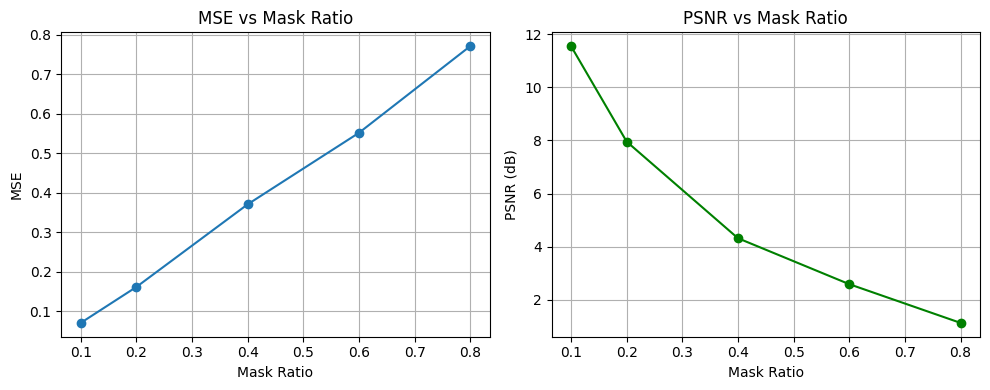

In [15]:
ratios, mses, psnrs = evaluate_model_vs_mask_ratio(model, test_loader)

# Plot MSE vs ratio
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(ratios, mses, marker='o')
plt.xlabel('Mask Ratio')
plt.ylabel('MSE')
plt.title('MSE vs Mask Ratio')
plt.grid(True)

# Plot PSNR vs mask ratio
plt.subplot(1, 2, 2)
plt.plot(ratios, psnrs, marker='o', color='green')
plt.xlabel('Mask Ratio')
plt.ylabel('PSNR (dB)')
plt.title('PSNR vs Mask Ratio')
plt.grid(True)

# show plots
plt.tight_layout()
plt.show()


### What do you conclude from the above figures?

- On the left graph of MSE vs Mask Ratio, the mse increases as mask ratio increase. We could see that the more part of the image is missing(the ratio of mask) the harder of he model to inpaint accurately(Higher reconstruction error)
- On the right graph of PSNR vs Mask Ratio, PSNR decreases as mask ratio increases. For PSNR, the log decibal drops which means the reconstructed image quality is getting worsen as we have more pixel missing due to the mask.
- Both figure show that importance of context(pixel not missing) in autoregressive inpainting for regenerating the image.

## Programming Question 2: MNIST Generation with Real NVP
### General Overview
In this question, we implement a basic real NVP model for MNIST image generation. In our implementation, we use the alternative form of flow models we saw in Written Question 2.

### Data
Let us first load MNIST. We flatten MNIST, as we want $x$ to be a vector.

In [21]:
# Transform to [0,1] and flatten
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

# Load flattened MNIST
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

# construct data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

### Implementing Real NVP
We now implement realNVP unit. In this implementation, we assume $z = f_{\bold{w}} (x)$. Nevertheless, the other form is also accepted and will end to the same result. For _scaling_ and _translation_ models we use the following simple MLPs:

* Scaling: 2 Layer MLP with first later being ReLU-activated and the second layer being Tanh-activated
* Translation: 2 Layer MLP with first later being ReLU-activated and the second layer not activated

We implement both `forward` and `inverse` methods to map $x$ to $z$ and reverse.

In [23]:
class realNVP_Unit(nn.Module):
    def __init__(self, input_dim, hidden_dim, mask):
        super().__init__()
        # binary mask: 0s and 1s
        # this mask performs the split (used for coupling),
        # i.e., for x_{<r} mask == 1
        # for x_{>=r} mask == 0
        self.mask = mask

        # Scaling network (MLP)
        self.scale_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()
        )

        # Translation network (MLP)
        self.translate_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        s = self.scale_net(x * self.mask) * (1 - self.mask)
        z = x * self.mask + (1 - self.mask) * (x * torch.exp(s) + self.translate_net(x * self.mask) * (1 - self.mask))
        log_det_jacobian = torch.sum(s, dim=1)
        return z, log_det_jacobian

    def inverse(self, z):
        s = self.scale_net(z * self.mask) * (1 - self.mask)
        t = self.translate_net(z * self.mask) * (1 - self.mask)
        x = z * self.mask + (1 - self.mask) * ((z - t) * torch.exp(-s))
        return x

We can now use the `realNVP_Unit` to implement a deep RealNVP model.

In [25]:
class RealNVP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_units):
        super().__init__()
        self.layers = nn.ModuleList()
        self.masks = [self._create_mask(i, input_dim) for i in range(num_units)]

        # COMPLETE make multiple layers of realNVP unit
        for i in range(num_units):
            self.layers.append(realNVP_Unit(input_dim, hidden_dim, self.masks[i]))
            
        # Set Latent to be Normal
        self.base_dist = torch.distributions.Normal(loc=torch.zeros(input_dim),scale=torch.ones(input_dim))



    def _create_mask(self, layer_idx, dim):
        # make a split for masking of your choice
        # A suggestion: alternating 0's and 1's
        mask = torch.zeros(dim)
        mask[layer_idx % 2::2] = 1
        mask = mask.to(device)
        return mask
        
    # go gradually from x to z
    def forward(self, x):
        log_det = 0
        for layer in self.layers:
            x, ld = layer(x)
            log_det += ld
        return x, log_det

    # go gradually from z to x
    def inverse(self, z):
        for layer in reversed(self.layers):
            z = layer.inverse(z)
        return z


    # compute log likelihood
    def log_likelihood(self, x):
        z, log_det = self.forward(x)
        base_dist = torch.distributions.Normal(loc=torch.zeros_like(z), scale=torch.ones_like(z))
        log_prob = base_dist.log_prob(z).sum(dim=1)
        return log_prob + log_det

    # sample from the model
    def sample(self, num_samples):
        return self.inverse(torch.randn(num_samples, 28 * 28).to(device))

Let's instantiate the model and take a sample from it to see how it looks like.

In [27]:
# fit the model to MNIST data
input_dim = 28 * 28
hidden_dim = 512
num_units = 6
model = RealNVP(input_dim, hidden_dim, num_units).to(device)

We now write a function to sample and plot our sample.

In [33]:
def sample_and_plot(model, num_samples=16):
    samples = model.sample(num_samples).view(-1, 1, 28, 28).cpu().detach().clamp(0, 1)

    grid = torch.cat([samples[i] for i in range(num_samples)], dim=2)
    plt.imshow(grid.squeeze(), cmap="gray")
    plt.axis("off")
    plt.title("Generated Samples")
    plt.show()


and use it to sample our model

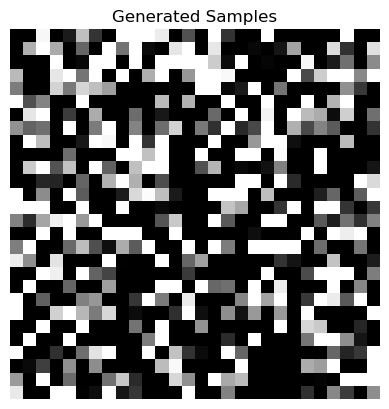

In [36]:
sample_and_plot(model, num_samples=1)

### Explain what you see.
 - The sample image ooks like a random noisy grid as no meaningful digit structure is visible.
 - As this image is sampled before training stage, it means this mapping is meaningless since only some Latent noise is sampled and passed through random function flow and only meaningless image is generated

### Training Loop
Let us now complete a training loop for the RealNVP Model.

In [38]:
def train(model, train_loader, num_epochs=20):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(num_epochs):
        total_loss = 0
        for x, _ in train_loader:
            x = x.to(device)

            # Compute loss and optimize
            loss = -model.log_likelihood(x).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


We now train our model.

In [40]:
# COMPLETE use `train`
train(model, train_loader, num_epochs=50)

Epoch [1/50], Loss: -1090.8405
Epoch [2/50], Loss: -1245.3195
Epoch [3/50], Loss: -1276.8445
Epoch [4/50], Loss: -1296.0738
Epoch [5/50], Loss: -1311.8158
Epoch [6/50], Loss: -1325.5430
Epoch [7/50], Loss: -1338.2823
Epoch [8/50], Loss: -1349.5235
Epoch [9/50], Loss: -1359.7710
Epoch [10/50], Loss: -1369.7481
Epoch [11/50], Loss: -1378.8546
Epoch [12/50], Loss: -1358.8569
Epoch [13/50], Loss: -1389.8423
Epoch [14/50], Loss: -1396.4745
Epoch [15/50], Loss: -1368.1219
Epoch [16/50], Loss: -1276.6901
Epoch [17/50], Loss: -1378.1505
Epoch [18/50], Loss: -1395.0805
Epoch [19/50], Loss: -1402.6526
Epoch [20/50], Loss: -1407.9678
Epoch [21/50], Loss: -1396.0594
Epoch [22/50], Loss: -1418.0274
Epoch [23/50], Loss: -1400.4317
Epoch [24/50], Loss: -1423.9259
Epoch [25/50], Loss: -1401.7106
Epoch [26/50], Loss: -1363.6074
Epoch [27/50], Loss: -1239.7735
Epoch [28/50], Loss: -1355.8190
Epoch [29/50], Loss: -1399.8339
Epoch [30/50], Loss: -1386.6324
Epoch [31/50], Loss: -1388.9621
Epoch [32/50], Lo

Let's sample the model once again.

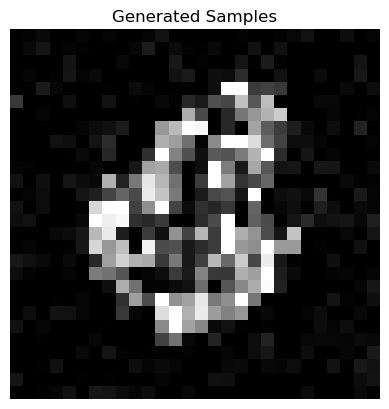

In [41]:
sample_and_plot(model, num_samples=1)

### Explain your observation.
- The generated sample after training has a clear structure resembling an MNIST digit (possibly a digit "6" ) —even though its still very blurry.
- This improvement from untrained mode could show that our RealNVP model has learned some meaningful mapping from the latent space to the MNIST image data space and captured some underlying data distribution. As the sample looks like a handwritten digit, this is the expected behavior for a trained flow-based generative model.
### Propose a metric to evaluate the quality of the generated image, which can explain the higher quality of the trained model as compared to untrained one.
- One metric that we could look into is the **Frechet Inception Distance (FID)** as discuessed in the Q4 of writing questions of this assignment.
- It could measures similarity between true distribution and generated images  distribution in data space.
- We could uses a pretrained network (e.g., Inception-V3 in Q4 paper) to extract high-level features. Computes the Fréchet distance between true and generated images' feature embeddings.
- Target: Lower FID - it could indicate better quality and diversity that is closer to true image data distribution. 